#Do Bye Weeks Matter?

###Participant: Lou Sherman
####Twitter: @loudogvideo

#Introduction
This project dives into the age-old question: Do Bye Weeks Matter? In my analysis, I find the maximum number of duplicated bye weeks per BBM 2 and BBM 3 team. I then compare advance rates of teams based on the total number of duplicated bye weeks. I also split out the data by position, since a duped bye week impacts QBs more than WR, for instance.

Frist, I load in the packages we will be using in this project

In [3]:
#import packages
import os
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Loading best ball data from 2021 and 2022

In [4]:
def fetch_csv_from_github(api_url):
    response = requests.get(api_url)
    if response.status_code == 200:
        data = response.json()
        csv_files = [file['download_url'] for file in data if file['name'].endswith('.csv')]
        df = pd.concat([pd.read_csv(url) for url in csv_files], ignore_index=True)
        return df
    else:
        print(f"Failed to fetch CSV from {api_url}. Status code: {response.status_code}")
        return None

data = pd.DataFrame()

# 2021 regular season data
github_api_url = "https://api.github.com/repos/fantasydatapros/best-ball-data-bowl/contents/data/2021/regular_season"
df = fetch_csv_from_github(github_api_url)
if df is not None:
    data = pd.concat([data, df])
    data['year'] = 2021

data = data.reset_index(drop=True)
data.head()

,draft_id,draft_time,clock,tournament_entry_id,tournament_round_number,player_name,position_name,bye_week,projection_adp,pick_order,overall_pick_number,team_pick_number,pick_points,roster_points,playoff_team,year
0,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,2021-08-28 17:06:42.031664+00:00,30,e1fdb4f8-4da3-4a09-8e6c-ef294c053251,1,Jalen Reagor,WR,14,139.48,1,144,12,31.2,1613.92,0,2021
1,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,2021-08-28 17:06:42.031664+00:00,30,b1e60f0c-2982-4e5c-8f80-da9a104cb290,1,Marquez Callaway,WR,6,107.46,6,115,10,81.9,1525.06,0,2021
2,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,2021-08-28 17:06:42.031664+00:00,30,b1e60f0c-2982-4e5c-8f80-da9a104cb290,1,Amari Cooper,WR,7,31.75,6,30,3,116.3,1525.06,0,2021
3,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,2021-08-28 17:06:42.031664+00:00,30,5388d065-c260-45cc-b9bf-fcb37f767d2c,1,Rhamondre Stevenson,RB,14,171.55,11,158,14,66.5,1669.72,1,2021
4,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,2021-08-28 17:06:42.031664+00:00,30,5388d065-c260-45cc-b9bf-fcb37f767d2c,1,Darrynton Evans,RB,13,201.35,11,203,17,2.8,1669.72,1,2021


Here, I create a new column in the data called 'position_bye" which is a concatenation of the position and bye week fields to create values such as "QB_9" or "WR_7." This field will be used later to help group players with similar byes AND positions.

In [5]:
# Create a DataFrame from your data (replace this with your actual DataFrame)
df = pd.DataFrame(data)
# Create a column for position with byes
df['position_bye'] = df['position_name'] + '_' + df['bye_week'].astype(str)

def get_unique_duplicate_counts_by_tournament_entry_id(df):
    unique_duplicate_counts_by_tournament_entry_id = {}

    grouped_data = df.groupby('tournament_entry_id')

    for tournament_entry_id, group_data in grouped_data:
        bye_weeks = group_data['bye_week']

        # Count all duplicates (keep=False) and then calculate the number of unique duplicates
        duplicate_count = bye_weeks.duplicated(keep=False).sum()
        unique_duplicate_counts_by_tournament_entry_id[tournament_entry_id] = duplicate_count

    return unique_duplicate_counts_by_tournament_entry_id

unique_duplicate_counts_by_tournament_entry_id = get_unique_duplicate_counts_by_tournament_entry_id(df)

Here is an example of how the new data would look for a specific entry.

In [6]:
 def get_duplicates_by_tournament_entry_id(df, tournament_entry_id):
    # Filter the DataFrame for the specific tournament_entry_id
    filtered_data = df[df['tournament_entry_id'] == tournament_entry_id]

    # Group the filtered data
    grouped_data = filtered_data.groupby('bye_week')

    duplicates_list = []

    for bye_week, group_data in grouped_data:
        # Check if the group has duplicates
        if len(group_data) > 1:
            # Append 'position_name' to the selected columns
            duplicates_list.append(group_data[['player_name', 'bye_week','position_bye','playoff_team']])

    if not duplicates_list:
        return None

    # Concatenate the list of DataFrame containing duplicates
    duplicates_df = pd.concat(duplicates_list)

    return duplicates_df

# Replace 'your_tournament_entry_id_here' with the actual ID you want to check for duplicates
desired_tournament_entry_id = '0000146a-e245-49c3-8a4e-8e739cfe1e46'
duplicates_for_entry_id = get_duplicates_by_tournament_entry_id(df, desired_tournament_entry_id)

if duplicates_for_entry_id is not None:
    print(f"Duplicates for Entry ID {desired_tournament_entry_id}:")
    print(duplicates_for_entry_id)
else:
    print(f"No duplicates found for Entry ID {desired_tournament_entry_id}.")

No duplicates found for Entry ID 0000146a-e245-49c3-8a4e-8e739cfe1e46.


Now, let's begin working with the data. Here, we group the entries by the bye week column and find the maximum number of same bye weeks for each entry. We then bring in the playoff team column from our original data set to calculate the average playoff rate (playoff advance rate).

Now, some of the counts have a low sample size, so I group them together into bucket for simplicity.

####We see a few things in the below data:
1. Most playoff teams have 4 or 5 players with a duped bye week.
2. Having more than 5 players on the same bye has a small, negative affect on your advance rate.

  count  playoff_team
0   2-3          2257
1     4          9671
2     5          8266
3    6+          5726


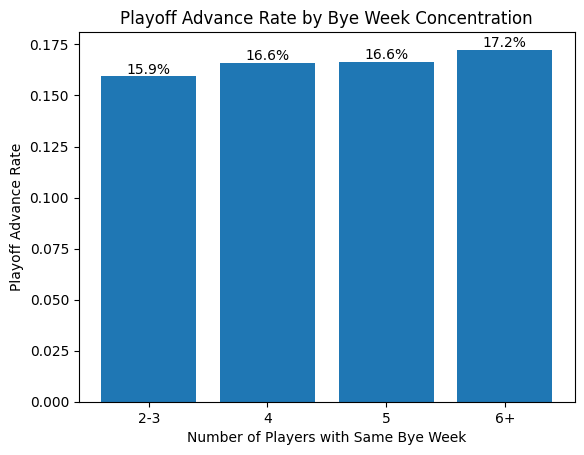

In [10]:
 # Group by draft_entry_id and bye_week to count players with the same bye week
bye_week_counts = df.groupby(['tournament_entry_id', 'bye_week']).size().reset_index(name='count')

# For each draft_entry_id, get the max count of players with the same bye week
max_bye_week_counts = bye_week_counts.groupby('tournament_entry_id')['count'].max().reset_index()

# Merge with original dataframe to get playoff_team values
merged = pd.merge(max_bye_week_counts, df[['tournament_entry_id', 'playoff_team']], on='tournament_entry_id', how='left').drop_duplicates()

# Define a function to group the buckets
def group_buckets(x):
    if x in [2, 3]:
        return '2-3'
    elif x >= 6:
        return '6+'
    else:
        return str(x)

# Apply the function to the 'count' column
merged['count'] = merged['count'].apply(group_buckets)

# Group by the max count (bucket) and calculate the rate of playoff_team = 1
playoff_rates = merged.groupby('count')['playoff_team'].mean().reset_index()

# Group by the max count (bucket) and calculate the total count of teams
playoff_counts = merged.groupby('count')['playoff_team'].sum().reset_index()

print(playoff_counts)

# Plot
plt.bar(playoff_rates['count'], playoff_rates['playoff_team'])
plt.xlabel('Number of Players with Same Bye Week')
plt.ylabel('Playoff Advance Rate')
plt.title('Playoff Advance Rate by Bye Week Concentration')

# Add the percentage on each bar
for i, v in enumerate(playoff_rates['playoff_team']):
    plt.text(i, v, f"{v*100:.1f}%", ha='center', va='bottom')

plt.show()

Now let's start to break things down by position. Here we filter by QBs. Most teams (~84%) have avoided duplicated bye weeks on QBs, with a small sample (<1%) of teams having 3 or more.

  count  playoff_team
0     1         22776
1     2          3089
2    3+            55
  Bucket  Number of Unique Players
0      1                    133436
1      2                     21445
2     3+                       494


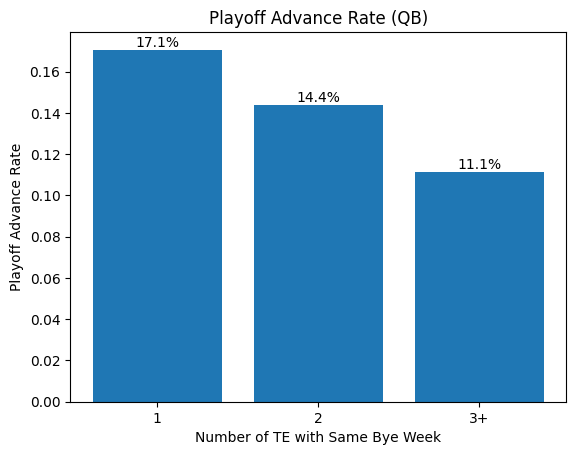

In [8]:
filtered_df = df[df['position_name'] == 'QB']

# Group by draft_entry_id and bye_week to count players with the same bye week
bye_week_counts = filtered_df.groupby(['tournament_entry_id', 'position_bye']).size().reset_index(name='count')

# For each draft_entry_id, get the max count of players with the same bye week
max_bye_week_counts = bye_week_counts.groupby('tournament_entry_id')['count'].max().reset_index()

# Merge with the original DataFrame to get playoff_team values
merged = pd.merge(max_bye_week_counts, filtered_df[['tournament_entry_id', 'playoff_team']], on='tournament_entry_id', how='left').drop_duplicates()

# Define a function to group the buckets
def group_buckets(x):
    if x >= 3:
        return '3+'
    else:
        return str(x)

# Apply the function to the 'count' column
merged['count'] = merged['count'].apply(group_buckets)

# Group by the new 'count' groups and calculate the rate of playoff_team = 1
playoff_rates = merged.groupby('count')['playoff_team'].mean().reset_index()

# Group by the max count (bucket) and calculate the total count of teams
playoff_counts = merged.groupby('count')['playoff_team'].sum().reset_index()

print(playoff_counts)

# Count the number of unique players in each bucket after grouping
unique_players_after_grouping = merged.groupby('count')['tournament_entry_id'].nunique().reset_index()
unique_players_after_grouping.columns = ['Bucket', 'Number of Unique Players']

print(unique_players_after_grouping)

# Plot
plt.bar(playoff_rates['count'], playoff_rates['playoff_team'])
plt.xlabel('Number of TE with Same Bye Week')
plt.ylabel('Playoff Advance Rate')
plt.title(f'Playoff Advance Rate (QB)')

# Add the percentage on each bar
for i, v in enumerate(playoff_rates['playoff_team']):
    plt.text(i, v, f"{v*100:.1f}%", ha='center', va='bottom')

plt.show()

Now for the fun part. In this step, we break out maximum bye weeks by position. Does it matter if you have a QB stacked with a WR with the same bye week? Probably not. We do want to know, however, the impact of having multiple RB from the same bye week.

####We see a few things in the below data:
1. Most teams (~84%) have avoided duplicated bye weeks on QBs, with a small sample (<1%) of teams having 3 or more.
2. The most significant drop off comes from RBs. However, RB and WR have a smaller sample of players without duping bye weeks (presumably due to stacking).
3. The flattest rates come from TEs

  Bucket  Number of Unique Players
0      1                    133436
1      2                     21445
2     3+                       494
  Bucket  Number of Unique Players
0      1                     48367
1      2                     91757
2     3+                     15251
  Bucket  Number of Unique Players
0      1                      5587
1      2                     84117
2     3+                     65671
  Bucket  Number of Unique Players
0      1                    133725
1      2                     21079
2     3+                       571


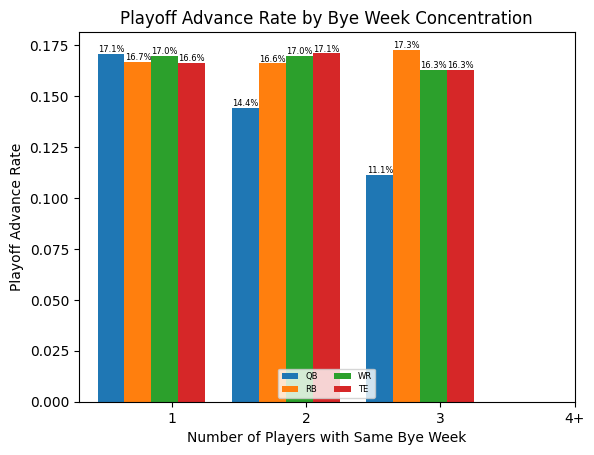

In [19]:
#Filter the DataFrame for the position_name 'QB'
position_name_qb = "QB"
filtered_df_qb = df[df['position_name'] == 'QB']

# Filter the DataFrame for the position_name 'RB'
df['position_name'] = df['position_name'].replace('FB', 'RB')
position_name_rb = "RB"
filtered_df_rb = df[df['position_name'] == 'RB']

# Filter the DataFrame for the position_name 'WR'
position_name_wr = "WR"
filtered_df_wr = df[df['position_name'] == 'WR']

# Filter the DataFrame for the position_name 'TE'
position_name_te = "TE"
filtered_df_te = df[df['position_name'] == 'TE']

# Function to group the buckets
def group_buckets(x):
    if x >= 3:
        return '3+'
    else:
        return str(x)

# Create a function to plot the data for each position
def plot_position_data(position_df, position_name, position_index, total_positions):
    # Group by draft_entry_id and bye_week to count players with the same bye week
    bye_week_counts = position_df.groupby(['tournament_entry_id', 'position_bye']).size().reset_index(name='count')

    # For each draft_entry_id, get the max count of players with the same bye week
    max_bye_week_counts = bye_week_counts.groupby('tournament_entry_id')['count'].max().reset_index()

    # Merge with the original DataFrame to get playoff_team values
    merged = pd.merge(max_bye_week_counts, position_df[['tournament_entry_id', 'playoff_team']], on='tournament_entry_id', how='left').drop_duplicates()

    # Apply the function to the 'count' column
    merged['count'] = merged['count'].apply(group_buckets)

    # Group by the new 'count' groups and calculate the rate of playoff_team = 1
    playoff_rates = merged.groupby('count')['playoff_team'].mean().reset_index()

    # Count the number of unique players in each bucket after grouping
    unique_players_after_grouping = merged.groupby('count')['tournament_entry_id'].nunique().reset_index()
    unique_players_after_grouping.columns = ['Bucket', 'Number of Unique Players']

    print(unique_players_after_grouping)

    # Set the width of the bars and adjust x position for side-by-side placement
    bar_width = 0.2
    x_positions = np.arange(len(playoff_rates)) + (bar_width * (position_index - total_positions/2))

    # Plot
    plt.bar(x_positions, playoff_rates['playoff_team'], width=bar_width, label=position_name)

     # Add the percentage on each bar
    for i, v in enumerate(playoff_rates['playoff_team']):
        plt.text(x_positions[i], v, f"{v*100:.1f}%", ha='center', va='bottom', fontsize=6)

# Plot data for 'QB'
plot_position_data(filtered_df_qb, position_name_qb, 1, 4)

# Plot data for 'RB'
plot_position_data(filtered_df_rb, position_name_rb, 2, 4)

# Plot data for 'WR'
plot_position_data(filtered_df_wr, position_name_wr, 3, 4)

# Plot data for 'TE'
plot_position_data(filtered_df_te, position_name_te, 4, 4)

plt.xlabel('Number of Players with Same Bye Week')
plt.ylabel('Playoff Advance Rate')
plt.title('Playoff Advance Rate by Bye Week Concentration')
plt.xticks(np.arange(len(playoff_rates)) + 0.25, playoff_rates['count'])
legend = plt.legend(loc='lower center', frameon=True, ncol=2, fontsize=6)

plt.show()

##Conclusion
The bye week bros might be on to something here. From the sample data, we can conclude that teams that have less duplicated bye weeks amongst their lineups are expected to have a higher chance at making the playoffs in Best Ball Mania.

The data also seems to show that as you continue to add more players with the same bye week, there are "diminishing returns." The example of this is for the WR position, where the advance rate of teams is relatively the same as you go from 2 to 4 duplicated bye weeks. You can also see the overall lineup advance rate flattens out at 5+ duplicated bye weeks.

We might not have enough data yet to come up with a concrete conclusion. It would be interesting to re-run this project in a couple years with more data points. But as it stands now, don't get carried away with too many players on the same bye week.